In [1]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_community.document_loaders import BSHTMLLoader # BeautifulSoup HTML Loader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import BSHTMLLoader # <--- HTML LOADER
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [2]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.environ.get('LANGCHAIN_API_KEY')

In [3]:
os.environ["GOOGLE_API_KEY"] = os.environ.get('GOOGLE_GEMNI_API_KEY')

In [4]:
HTML_FILE_PATH = 'Source_Material/Example_game.html'
GENERATION_MODEL_NAME = "gemini-2.5-flash-preview-05-20"

In [6]:
LLM = ChatGoogleGenerativeAI(
    model=GENERATION_MODEL_NAME,
    temperature=0.2,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [26]:
code_LLM = ChatGoogleGenerativeAI(
    model=GENERATION_MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [7]:
# --- 1. Load Raw HTML and Extract Text ---
print(f"1. Processing HTML from '{HTML_FILE_PATH}'...")
raw_html_content = ""
extracted_text_content = ""
try:
    with open(HTML_FILE_PATH, 'r', encoding='utf-8') as f:
        raw_html_content = f.read()

    from bs4 import BeautifulSoup
    soup = BeautifulSoup(raw_html_content, 'html.parser')
    for unwanted_tag in soup(["script", "style", "nav", "footer", "aside"]): # Customize as needed
        unwanted_tag.decompose()
    extracted_text_content = soup.get_text(separator='\n', strip=True)
except Exception as e:
    print(f"🔴 Error processing HTML: {e}")
    exit()

1. Processing HTML from 'Source_Material/Example_game.html'...


In [8]:
print(f"   Raw HTML length (chars): {len(raw_html_content)}")
print(f"   Extracted text length (chars): {len(extracted_text_content)}")

   Raw HTML length (chars): 165650
   Extracted text length (chars): 29744


In [21]:
interpreter_template = """You are a business analyst, an expert at interpreting stakeholders and translating them to technical requirements. You will do three things before responding
1. Take in the question and determine the best visualization to go along with the question.
2. Come up with the best way to extract the data necessary from the given file, for example, writing Python code to parse an HTML file.
3. Ensure that the data needed for the visualization is in the given file.

After evaluating the question on the question. Given specific details on the approach the engineer should take in order to write the Python code necessary for the visualization.

Provided a description of the purpose and pseudo code for the engineer.

**DO NOT WRITE ANY CODE**

Given File:
---
{raw_html_source}
---

User Question: {question}

**DO NOT WRITE ANY CODE**
Content Answer:"""
interpreter_prompt = PromptTemplate.from_template(interpreter_template)
interpreter_chain = (
    {
        "raw_html_source": RunnableLambda(lambda x: raw_html_content), # Always provide full extracted text
        "question": RunnablePassthrough() # Pass the original question
    }
    | interpreter_prompt
    | LLM
    | StrOutputParser()
)

In [35]:
engineer_template = """You are an expert python software engineer, you specialize in extracting data and visualizations. The only output given should be a python code block. 
You will get technical requirements from a business analyst.

**IMPORTANT INSTRUCTIONS:**
-   **DO NOT include the provided 'Raw HTML Source Code' as a string literal within the generated Python script.**
-   Assume the HTML content will be loaded into a variable named `html_content` within the Python script. Your script should operate on this `html_content` variable.
-   Provide only the Python code block enclosed in ```python ... ```.
-   The script should be runnable if the `html_content` variable is pre-populated with the HTML.
-   The script should run and create the visualization without any additions such as calling a function.
-   Use HTML_FILE_PATH as an existing variable for the HTML file, assume this variable is already set and does not need to be defined.
-   Use with open(HTML_FILE_PATH, encoding="utf-8") as f: soup = BeautifulSoup(f, "lxml") method to open HTML files.
-   When getting values from pandas columns always use .values, for example, df['column_name'].values.

**IMPORTANT INFORMATION:**
-   Pandas version being used is 2.1.4.
-   matplotlib version being used is 3.5.1.
-   BeautifulSoup version being used is 4.11.1.

Technical Requirements:
---
{technical_requirements}
---

Given File:
---
{raw_html_source}
---

Code Block:"""
engineer_template_prompt = PromptTemplate.from_template(engineer_template)
engineer_prompt_chain = (
    {
        "raw_html_source": RunnableLambda(lambda x: raw_html_content), # Always provide full extracted text
        "technical_requirements": RunnablePassthrough() # Pass the original question
    }
    | engineer_template_prompt
    | code_LLM
    | StrOutputParser()
)

In [36]:
def ask_intelligent_assistant(user_question, code=False):
    if code:
        response = engineer_prompt_chain.invoke(user_question)
    else:
        response = interpreter_chain.invoke(user_question)
    
    return response

In [37]:
import re
def extract_code_blocks(markdown_text):
    code_blocks = []
    pattern = r"```(?P<language>\w*)\n(?P<code>[\s\S]*?)```"
    matches = re.finditer(pattern, markdown_text)
    for match in matches:
        language = match.group("language")
        code = match.group("code").strip()
        code_blocks.append({"language": language, "code": code})
    return code_blocks

In [ ]:
response = ask_intelligent_assistant('''
    What led to the Pacers beating the Knicks?
    ''')
print(response)
code_output=ask_intelligent_assistant(response, code=True)
print(code_output)

In [48]:
l
code_blocks = extract_code_blocks(response)
#print(code_blocks[1])
runnable = True
i = 0
while runnable:
    print(i)
    if i == 3:
        runnable = False
    try:
        i+=1
        exec(code_blocks[1]['code'])
        runnable = False
    except Exception as e:
        print("An error occurred:", e)
        response = ask_intelligent_assistant('''
    What led to the Pacers beating the Knicks?
    ''', error=True)
        print(response)
        
    

NameError: name 'l' is not defined

In [84]:
def make_error_section(error_msg, prev_code):
    if error_msg:
        return f"Previous attempt failed with error:\n{error_msg}\nPlease fix the Python code above. The previous code was: ```python {prev_code} ```"
    else:
        return ""

In [85]:
def execute_code(code_str):
    print(code_str)
    try:
        exec(code_str)
        return None  # No error
    except Exception as e:
        return str(e)

Output:  As a business analyst, I've interpreted your request to understand the game's dynamics and identify the key factors that led to the Indiana Pacers' victory over the New York Knicks. The most effective way to visualize this is through a **Score Progression Line Chart**, which will clearly illustrate how the score evolved over time for both teams, highlighting periods of dominance, lead changes, and scoring runs.

The provided HTML file contains a detailed play-by-play (`pbp`) table, which is precisely what we need. This table includes timestamps and the cumulative score at each event, making it ideal for constructing our score progression chart.

---

### **Purpose of the Visualization**

The primary purpose of this visualization is to provide a clear, chronological overview of the game's scoring. By plotting the scores of both the New York Knicks and the Indiana Pacers against elapsed game time, we can:

1.  **Identify Lead Changes:** Easily see when one team took the lead and

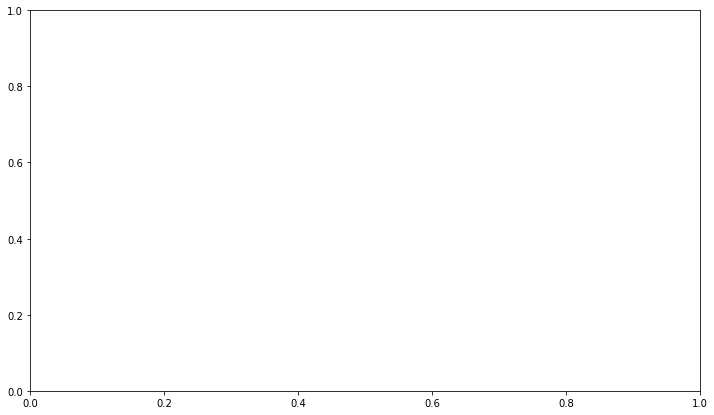

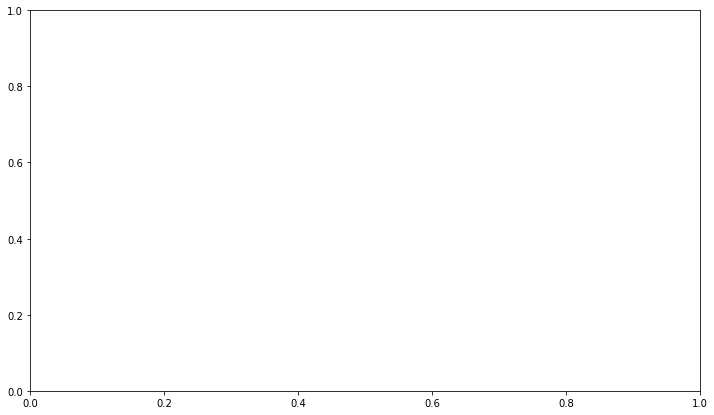

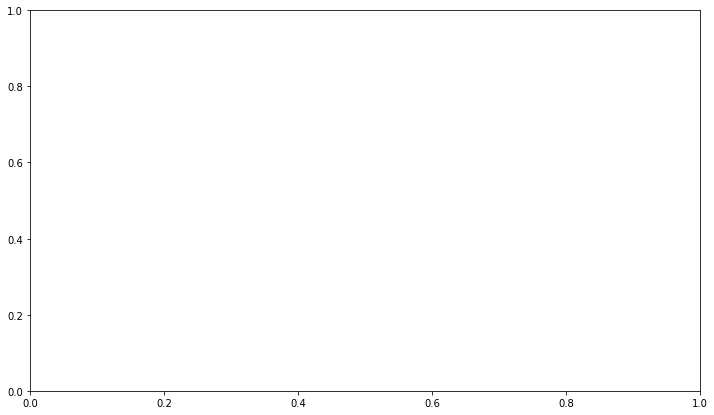

In [86]:
question = '''
    What led to the Pacers beating the Knicks?
    '''
MAX_ATTEMPTS = 3

attempt = 0
error_msg = None
code_to_run = None

while attempt < MAX_ATTEMPTS:
    # Compose the error section for the prompt
    error_section = make_error_section(error_msg, code_to_run)

    # (Re)build your prompt with any error message
    interpreter_prompt = PromptTemplate.from_template(interpreter_template)
    interpreter_chain = (
        {
            "raw_html_source": RunnableLambda(lambda x: raw_html_content),
            "question": RunnablePassthrough(),
            "error_section": RunnableLambda(lambda x: error_section)
        }
        | interpreter_prompt
        | LLM
        | StrOutputParser()
    )

    code_str = interpreter_chain.invoke(question)
    print('Output: ', code_str)
    # If LLM returns full markdown, extract just code
    import re
    match = re.search(r"```python(.*?)```", code_str, re.DOTALL)
    code_to_run = match.group(1).strip() if match else code_str.strip()
    error_msg = execute_code(code_to_run)
    if not error_msg:
        print('Working Code: ', code_to_run)
        exec(code_to_run)
        print("Execution SUCCESS!")
        break
    else:
        print(f"Attempt {attempt+1} failed with error: {error_msg}")
        attempt += 1

if error_msg:
    print(f"All {MAX_ATTEMPTS} attempts failed. Last error: {error_msg}")

In [68]:
code_to_run

'...'

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

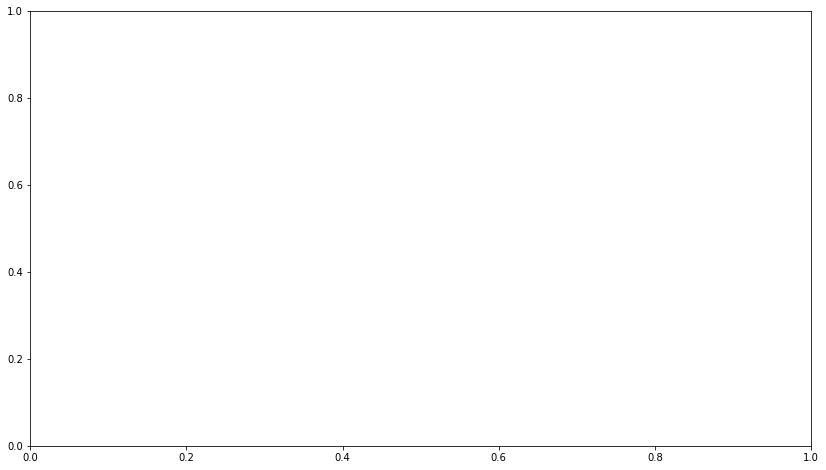

In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Assume HTML_FILE_PATH is an existing variable for the HTML file,
# e.g., HTML_FILE_PATH = "path/to/your/game_data.html"
# The script will load the HTML content from this file.

# Data extraction
elapsed_game_seconds = []
knicks_cumulative_scores = []
pacers_cumulative_scores = []

SECONDS_PER_QUARTER = 12 * 60  # 12 minutes per NBA quarter
current_quarter_offset_seconds = 0
current_quarter_number = 0

# Load the HTML content from the file
# As per instructions, assume HTML_FILE_PATH is set and load content into soup.
with open(HTML_FILE_PATH, encoding="utf-8") as f:
    soup = BeautifulSoup(f, "lxml")

pbp_table = soup.find("table", id="pbp")

if pbp_table:
    for row in pbp_table.find_all("tr"):
        # Check if the row is a quarter header
        if 'class' in row.attrs and 'thead' in row['class'] and row.get('id', '').startswith('q'):
            current_quarter_number += 1
            # Update the offset for the start of the new quarter (if not the first quarter)
            if current_quarter_number > 1:
                current_quarter_offset_seconds = (current_quarter_number - 1) * SECONDS_PER_QUARTER
            continue  # Skip processing this header row as a play event

        # Attempt to find all td elements in the row
        tds = row.find_all("td")

        # Ensure there are enough columns and the score column has content
        if len(tds) < 4:
            continue

        time_cell = tds[0]
        score_cell = tds[3]

        time_str = time_cell.get_text().strip()
        score_text = score_cell.get_text().strip()

        # Skip rows without a valid time or score format
        if not time_str or ':' not in time_str or not score_text or '-' not in score_text:
            continue

        try:
            # Parse minutes and seconds from the time string (e.g., "11:36.0")
            minutes_str, seconds_str = time_str.split(':')
            minutes_in_quarter = int(minutes_str)
            seconds_in_quarter = int(float(seconds_str)) # Handle ".0"

            # Calculate seconds elapsed within the current quarter (time counts down)
            seconds_elapsed_in_current_quarter = SECONDS_PER_QUARTER - (minutes_in_quarter * 60 + seconds_in_quarter)

            # Calculate the absolute time from the start of the game
            absolute_time_in_seconds = current_quarter_offset_seconds + seconds_elapsed_in_current_quarter
            elapsed_game_seconds.append(absolute_time_in_seconds)

            # Split the score string into Knicks and Pacers scores (e.g., "121-130")
            knicks_score_str, pacers_score_str = score_text.split('-')
            knicks_score = int(knicks_score_str)
            pacers_score = int(pacers_score_str)
            knicks_cumulative_scores.append(knicks_score)
            pacers_cumulative_scores.append(pacers_score)

        except ValueError:
            # If parsing fails for time or score, skip this row
            continue
else:
    print("Error: Play-by-play table with id='pbp' not found in the HTML content.")
    # Exit or handle the error as appropriate for your application
    exit()

# Create a Pandas DataFrame from the extracted data
game_data = pd.DataFrame({
    "time_in_seconds": elapsed_game_seconds,
    "knicks_score": knicks_cumulative_scores,
    "pacers_score": pacers_cumulative_scores
})

# Visualization: Dual-Line Chart
plt.figure(figsize=(14, 8)) # Adjust figure size for better readability

# Plot the Knicks' score progression
plt.plot(game_data["time_in_seconds"], game_data["knicks_score"], 
         label="New York Knicks Score", color="blue", linewidth=2)

# Plot the Pacers' score progression
plt.plot(game_data["time_in_seconds"], game_data["pacers_score"], 
         label="Indiana Pacers Score", color="gold", linewidth=2)

# Set chart title and axis labels
plt.title("Game 4 Score Progression: New York Knicks vs. Indiana Pacers", fontsize=16)
plt.xlabel("Elapsed Game Time (Seconds)", fontsize=12)
plt.ylabel("Cumulative Score", fontsize=12)

# Add a legend to distinguish the lines
plt.legend(fontsize=10)

# Add vertical lines to mark quarter boundaries for better context
# Assuming 4 quarters of 12 minutes (720 seconds) each
quarter_boundaries = [SECONDS_PER_QUARTER, 2 * SECONDS_PER_QUARTER, 3 * SECONDS_PER_QUARTER]
for i, q_time in enumerate(quarter_boundaries):
    # Only draw if the boundary is within the actual game duration
    if q_time < game_data["time_in_seconds"].max():
        plt.axvline(x=q_time, color='gray', linestyle='--', linewidth=0.8, 
                    label=f'End of Q{i+1}' if i == 0 else "") # Label only first boundary to avoid clutter

plt.grid(True, linestyle=':', alpha=0.7) # Add a grid for easier reading
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()